# Exploratory Data Analysis

This notebook contains my exploratory data analysis of the SEER data and is split into the following sections:

### 1. [Setup](#setup)

### 2. [Extract Data from Raw Text File](#extract)

### 3. [Data Summary](#summary)

### 4. [Incidence by state and county](#state-county)

### 5. [*Exploring an aspect a skeptic would worry about*: Incidence by race group](#race)


***
<a id="setup"></a>
## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import os
import us
from matplotlib import pyplot as plt
from collections import Counter

In [2]:
color_palette = {0:"#f8f8ff", 1:"#ffe4e1", 2:"#ffa07a", 3:"#e9967a", 4:"#fa8072", 5:"#cd5c5c", 6:"#b22222", 7:"#8b0000"}

In [3]:
# project data directory
data_dir = '/Users/shandu/Documents/2019_Fall/statistics/final-project/data/'

In [4]:
# file with raw breast cancer data
breast_cancer_file = data_dir + 'SEER_1975_2016_TEXTDATA/incidence/yr1975_2016.seer9/BREAST.TXT'

# file with parameters used in SAS data processing
params_file = data_dir + 'sas-dataprocessing-parameters.txt'

<a id="extract"></a>
## 2.  Extract Data from Raw Text File

All of the breast cancer incidence data are stored in a single text file which cannot be read by `pandas.read_csv()`. So I have parsed the data manually, using parameters from a file for SAS processing of these data (`"sas-dataprocessing-parameters.txt"`).

This large text file was divided into 100 smaller files which were then each parsed and converted into dataframe.

In [5]:
### Obtain start indices, column names and data lengths #
  # for the datapoints in each column ###

char_ixs = [] #stores the start indices for each datapoint in each column
sas_names = [] #stores the column names used in SAS processing code
data_lengths = [] #stores the lengths of datapoints in specific columns
naaccr_names = [] #stores the NAACCR name for the column

with open(params_file, 'r') as in_f:
    
    line = in_f.readline()
    
    while line:
        
        if '@' in line:
 
            line = line.strip().split('@ ')
            line_components = [comp for comp in line[1].split(' ') if comp != '']
            
            char_i = int(line_components[0])
            char_ixs.append(char_i-1) #subtract 1 because of 0-indexing
            
            sas_n = line_components[1]
            sas_names.append(sas_n)
            
            data_length = int(line_components[2].split('$char')[1].split('.')[0])
            data_lengths.append(data_length)
            
            naaccr_n = line[1].split('/* ')[1].strip(' */')
            naaccr_names.append(naaccr_n)  
            
        line = in_f.readline()

In [6]:
len(char_ixs), len(sas_names), len(data_lengths), len(naaccr_names)

(143, 143, 143, 143)

In [7]:
naaccr_names[-1] = naaccr_names[-1].strip(' */     ;') #remove end of file formatting

In [8]:
column_name_map = {sas_names[i]:naaccr_names[i] for i in range(len(sas_names))}

In [9]:
# store data structures for later use
#pd.Series(char_ixs).to_pickle(data_dir+'pickles/char_ixs.pkl')
#pd.Series(sas_names).to_pickle(data_dir+'pickles/sas_names.pkl')
#pd.Series(data_lengths).to_pickle(data_dir+'pickles/data_lengths.pkl')
#pd.Series(naaccr_names).to_pickle(data_dir+'pickles/naaccr_names.pkl')
#pd.Series(column_name_map).to_pickle(data_dir+'pickles/column_name_map.pkl')

In [10]:
# read in pickled files
char_ixs = list(pd.read_pickle(data_dir+'pickles/char_ixs.pkl'))
sas_names = list(pd.read_pickle(data_dir+'pickles/sas_names.pkl'))
data_lengths = list(pd.read_pickle(data_dir+'pickles/data_lengths.pkl'))
naaccr_names = list(pd.read_pickle(data_dir+'pickles/naaccr_names.pkl'))
column_name_map = dict(pd.read_pickle(data_dir+'pickles/column_name_map.pkl'))

In [11]:
### Cut raw data into chunks ###
file_size = 840666
c_size = 8406
num_files = 100

output_dir = data_dir + 'raw_data_chunks/'

In [ ]:
print("num files created:", end=" ")
end = c_size

for i in range(num_files):
    
    os.system('head -'+str(end)+' '+breast_cancer_file+' | tail -'+str(c_size)+' > '+output_dir+'breast'+str(i)+'.txt')
    
    end = end + c_size
    if i%10 == 0:
        print(i, end=" ")

i = 100
print(i)
os.system('head -'+str(file_size)+' '+breast_cancer_file+' | tail -'+str(file_size-(end-c_size))+' > '+output_dir+'breast'+str(i)+'.txt')

num files created: 0 10 

In [ ]:
all_raw_files = os.listdir(data_dir+'/raw_data_chunks/')
output_dir = data_dir + 'raw_data_pickles/'

In [ ]:
### Convert raw data into dataframes pickle files ###

print("files completed:", end=" ")

for file_i in range(90,101):
        
    cur_file = data_dir + '/raw_data_chunks/breast' + str(file_i) + '.txt'
    
    line_count = 0
    df_num = 0
    df = pd.DataFrame(columns=sas_names)
    df_i = 0
    
    with open(cur_file, 'r') as in_f:

        line = in_f.readline().strip()
        
        while line:
            
            if line_count > 1000:

                df.to_pickle(output_dir+'breast'+str(file_i)+'-'+str(df_num)+'.pkl')
                
                line_count = 0
                del df
                df_num += 1
                df = pd.DataFrame(columns=sas_names)
                df_i = 0
            
            line_count += 1
            row_entry = []
            for i in range(len(char_ixs)):
                start = char_ixs[i]
                length = data_lengths[i]
                
                data = line[start:start+length]
                if " " in data:
                    data = np.nan #deal with missing data
                row_entry.append(data)
            df.loc[df_i, :] = row_entry
            df_i += 1
            
            line = in_f.readline().strip()
            
        # no more lines
        # final file has fewer than 1000 lines
        df.to_pickle(output_dir+'breast'+str(file_i)+'-'+str(df_num)+'.pkl')
            
    
    print(file_i, end=" ")



<a id="summary"></a>
## 3. Data Summary

The record description file for the SEER data can be found [here](https://seer.cancer.gov/data-software/documentation/seerstat/nov2018/TextData.FileDescription.pdf).

- Time period (for years of diagnosis): 1975 to 2016
- Number of records: 840 666
- Number of datapoints: 143
- Data come from SEER registries in the following states: Connecticut, New Mexico, Washington, Hawaii, Georgia, California, Michigan, Utah and Iowa.

consistent with report on data found here
All code used to produce these statistics can be found below.

In [5]:
column_name_map_df = pd.read_csv(data_dir+'sas-to-naaccr-name.csv')
column_name_map_df

,sas,naaccr
0,PUBCSNUM,Patient ID
1,REG,SEER registry
2,MAR_STAT,Marital status at diagnosis
3,RACE1V,Race/ethnicity
4,NHIADE,NHIA Derived Hisp Origin
5,SEX,Sex
6,AGE_DX,Age at diagnosis
7,YR_BRTH,Year of birth
8,SEQ_NUM,Sequence number
9,MDXRECMP,Month of diagnosis


In [6]:
data_source = data_dir+'/raw_data_pickles/'
all_data_files = [x for x in os.listdir(data_source) if x != '.DS_Store']

#### Time frame
Confirm that time frame is from 1975 to 2016.

In [7]:
min_year = float('inf')
max_year = float('-inf')

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    years = df.YEAR_DX.astype(int)
    if min(years) < min_year:
        min_year = min(years)
    if max(years) > max_year:
        max_year = max(years)
        
print("Earliest year on record:", min_year)
print("Latest year on record:", max_year)

Earliest year on record: 1975
Latest year on record: 2016


#### Number of records

In [8]:
total_num_records = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    total_num_records += df.shape[0]
    
print("Number of records:", total_num_records)

Number of records: 840666


#### Number of datapoints

In [9]:
print("Number of datapoints/columns:", len(pd.read_pickle(data_source+all_data_files[0]).columns))

Number of datapoints/columns: 143


<a id="state-county"></a>
## 4. Incidence by state and by county
Tally the raw number of diagnoses from 1975-2016 in each county, state and state-county pair.

> **`ST_CNTY`** stores the state county code (first two digist represent state, last 3 represent county)

In [10]:
state_counts = {'zero':0} #dummy value to ensure type match
county_counts = {'zero':0}
state_county_counts = {'zero':0}

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    sc_codes = list(df.ST_CNTY)
    states = [x[:2] for x in sc_codes]
    counties = [x[2:] for x in sc_codes]
    state_counties = [x for x in sc_codes]
   
    Counter.update(state_counts, Counter(states))
    Counter.update(county_counts, Counter(counties))
    Counter.update(state_county_counts, Counter(state_counties))
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [11]:
state_counts.pop('zero')
county_counts.pop('zero')
state_county_counts.pop('zero')

0

In [12]:
for s_code in state_counts:
    print(us.states.lookup(s_code))

Connecticut
New Mexico
Washington
Hawaii
Georgia
California
Michigan
Utah
Iowa


In [13]:
state_counts_df = pd.DataFrame(pd.Series(state_counts))
state_counts_df = state_counts_df.reset_index()
state_counts_df = state_counts_df.rename(columns={'index':'state_code', 0:'count'})
state_counts_df = state_counts_df.sort_values(by='state_code')
state_counts_df = state_counts_df.reset_index()
state_counts_df = state_counts_df.drop('index', axis=1)

In [14]:
state_counts_df = pd.read_csv(data_dir+'state_counts.csv')
state_counts_df.iloc[0,0] = '06'
state_counts_df.iloc[1,0] = '09'
state_counts_df.state_code.astype(str)
state_counts_df = state_counts_df.sort_values(by='count', ascending=False)
state_counts_df

,state_code,count
0,06,137103
5,26,136820
1,09,133094
8,53,132267
4,19,98470
2,13,76660
6,35,45262
7,49,44103
3,15,36887


In [15]:
state_labels = [us.states.lookup(str(x)) for x in state_counts_df.state_code]
print(state_labels)

[<State:California>, <State:Michigan>, <State:Connecticut>, <State:Washington>, <State:Iowa>, <State:Georgia>, <State:New Mexico>, <State:Utah>, <State:Hawaii>]


In [16]:
state_labels_for_graph = state_labels.copy()
state_labels_for_graph[2] = 'Conn.'

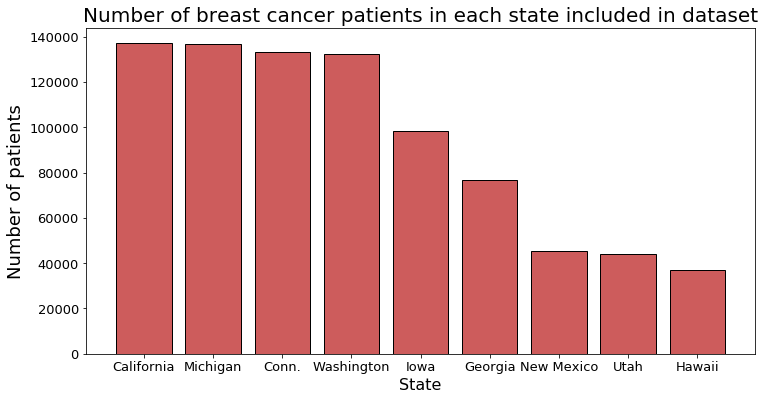

In [17]:
### Create bar graph ###

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x=np.arange(0,state_counts_df.shape[0]), height=state_counts_df['count'].astype(float), color=color_palette[5], edgecolor="black")
ax.set_title('Number of breast cancer patients in each state included in dataset', fontsize=20)
ax.set_ylabel('Number of patients', fontsize=18)
ax.set_xlabel('State', fontsize=16)
plt.xticks(ticks=np.arange(0, state_counts_df.shape[0]), labels=state_labels_for_graph)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("bargraph-raw-counts-state.jpeg")

plt.show()

In [18]:
state_populations_df = pd.read_csv(data_dir+'state_populations.csv')
state_populations_df = state_populations_df.set_index('State')
state_populations = [float(state_populations_df.loc[str(s), '2018_population']) for s in state_labels]
state_populations

[39557045.0,
 9995915.0,
 3572665.0,
 7535591.0,
 3156145.0,
 10519475.0,
 2095428.0,
 3161105.0,
 1420491.0]

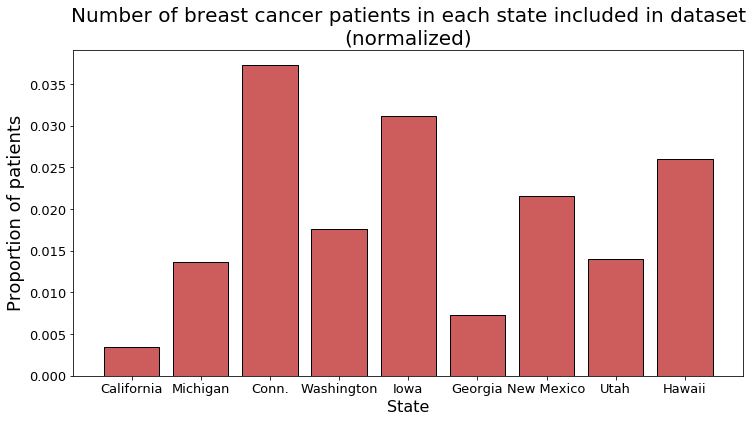

In [19]:
### Create bar graph normalized by state population ###

fig, ax = plt.subplots(figsize=(12,6))

heights = np.array(state_counts_df['count'].astype(float))/np.array(state_populations)

ax.bar(x=np.arange(0,state_counts_df.shape[0]), height=heights, color=color_palette[5], edgecolor="black")
ax.set_title('Number of breast cancer patients in each state included in dataset\n(normalized)', fontsize=20)
ax.set_ylabel('Proportion of patients', fontsize=18)
ax.set_xlabel('State', fontsize=16)
plt.xticks(ticks=np.arange(0, state_counts_df.shape[0]), labels=state_labels_for_graph)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("bargraph-normalized-counts-state.jpeg")

plt.show()

There are many more incidences of breast cancer in Connecticut than in California for example. Is this because there *is* actually a higher incidence rate in Connecticut or whether incidents go unreported in California? Rate might be lower in larger states because of the fact that there is a single SEER site in each state regardless of size.

In [20]:
county_counts_df = pd.DataFrame(pd.Series(county_counts))
county_counts_df = county_counts_df.reset_index()
county_counts_df = county_counts_df.rename(columns={'index':'county_code', 0:'count'})
county_counts_df = county_counts_df.sort_values(by='county_code')
county_counts_df = county_counts_df.reset_index()
county_counts_df = county_counts_df.drop('index', axis=1)

In [21]:
county_counts_df.to_csv(data_dir+'county_counts.csv', index=False)

In [22]:
state_county_counts_df = pd.DataFrame(pd.Series(state_county_counts))
state_county_counts_df = state_county_counts_df.reset_index()
state_county_counts_df = state_county_counts_df.rename(columns={'index':'state_county_code', 0:'count'})
state_county_counts_df = state_county_counts_df.sort_values(by='state_county_code')
state_county_counts_df = state_county_counts_df.reset_index()
state_county_counts_df = state_county_counts_df.drop('index', axis=1)

In [23]:
for i in state_county_counts_df.index:
    if state_county_counts_df.loc[i, 'state_county_code'][0] == '0':
        state_county_counts_df.loc[i, 'state_county_code'] = state_county_counts_df.loc[i, 'state_county_code'][1:]

In [24]:
state_county_counts_df.to_csv(data_dir+'state_county_counts.csv', index=False)

#### Exploring missing values

In [25]:
df = pd.read_pickle(data_source+all_data_files[0])

missing_vals_df = pd.DataFrame(columns=["datapoint", "missing_count"])
missing_vals_df = missing_vals_df.set_index("datapoint")
for c in df.columns:
    missing_vals_df.loc[c, "missing_count"] = 0

    
print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    for col in df.columns:
        cur_count = missing_vals_df.loc[col, "missing_count"] 
        for val in df[col]:
            if type(val) != str:
                if np.isnan(val):
                    cur_count += 1
        missing_vals_df.loc[col, "missing_count"] = cur_count 
        
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1
        
missing_vals_df = missing_vals_df.sort_values(by="missing_count", ascending=False)

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [26]:
missing_vals_df.to_csv('col_num_missing_values.csv')
missing_vals_df.head()

,missing_count
datapoint,
CS10SITE,840666.0
VASINV,840666.0
CS11SITE,840666.0
CS13SITE,840666.0
NHIADE,840666.0


In [27]:
non_zero_missing_df = missing_vals_df[missing_vals_df.missing_count > 0.1]

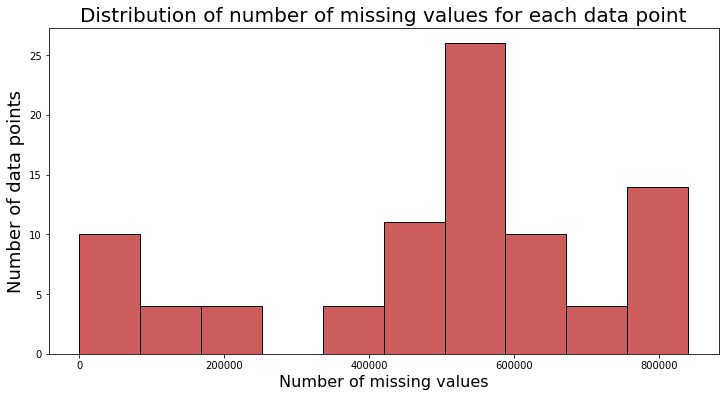

In [28]:
### Create bar graph of missing values ###

fig, ax = plt.subplots(figsize=(12,6))

ax.hist(non_zero_missing_df.missing_count, color=color_palette[5], edgecolor="black")
ax.set_title('Distribution of number of missing values for each data point', fontsize=20)
ax.set_ylabel('Number of data points', fontsize=18)
ax.set_xlabel('Number of missing values', fontsize=16)

plt.savefig("num-missing-values.jpeg")

plt.show()

In [29]:
column_name_map_df = column_name_map_df.set_index("sas")

In [30]:
print([column_name_map_df.loc[c, "naaccr"] for c in non_zero_missing_df.index])

['CS Site-Specific Factor 10', 'Lymph-vascular Invasion (2004+)', 'CS Site-Specific Factor 11', 'CS Site-Specific Factor 13', 'NHIA Derived Hisp Origin', 'Cs Site-specific Factor 8', 'CS Site-Specific Factor 12', 'CS Site-specific Factor 9', 'EOD 10 - path extension', 'CS Site-Specific Factor 16', 'EOD--old 2 digit', 'SEER Summary Stage 2000 2000 (2001-2003)', 'EOD--old 4 digit', 'EOD--old 13 digit', 'Number of lymph nodes', 'Scope of lymph node surgery 98-02', 'Surgery to other sites', 'SEER Summary Stage 1977 (1995-2000)', 'Derived AJCC T 7th ed', 'Derived AJCC N 7th ed', 'Derived AJCC M 7th ed', 'Derived AJCC 7 Stage Group', 'SEER Combined Mets at DX-liver (2010+)', 'CS Site-Specific Factor 15', 'CS Site-Specific Factor 7', 'SEER Combined Mets at DX-bone (2010+)', 'SEER Combined Mets at DX-brain (2010+)', 'SEER Combined Mets at DX-lung (2010+)', 'Insurance Recode (2007+)', 'CS Mets Eval', 'CS EXT/Size Eval', 'CS Nodes Eval', 'Tumor marker 2', 'Tumor marker 1', 'CS Tumor size', 'Deri

In [44]:
len([column_name_map_df.loc[c, "naaccr"] for c in non_zero_missing_df.index])

87

**Check if there are any column names that we care about for our analysis which have a high number of missing values**: none.

<a id="race"></a>
## 5. *Exploring an aspect a skeptic would worry about*: Incidence by race group

A skeptic may be concerned that since data come only from SEER registries in specific states, that the data are not a good representation of the entire US population. Most importantly, a skeptic may worry that cases are well-reported in one race group but under-reported in another race group. And this will impact any study on the racial disparities in breast cancer cases.

So I will investigate the SEER datasets breast cancer incidence coverage by race group.

> Race group is identified by a code in the **`RACEIV`** column.

In [31]:
race_counts = {'zero':0} #dummy value to ensure type match

print('files read (out of ' + str(len(all_data_files)) + '):', end=" ")
file_count = 0

for data_file in all_data_files:
    
    df = pd.read_pickle(data_source+data_file)
    
    race_codes = list(df.RACE1V)
    
    Counter.update(race_counts, Counter(race_codes))
    
    if file_count%50==0:
        print(file_count, end=" ")
        
    file_count += 1

files read (out of 901): 0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 

In [32]:
race_counts.pop('zero')

0

In [33]:
race_counts_df = pd.DataFrame(pd.Series(race_counts))
race_counts_df = race_counts_df.reset_index()
race_counts_df = race_counts_df.rename(columns={'index':'race_code', 0:'count'})
race_counts_df = race_counts_df.sort_values(by='race_code')
race_counts_df = race_counts_df.reset_index()
race_counts_df = race_counts_df.drop('index', axis=1)
race_counts_df.to_csv(data_dir+'race_counts.csv', index=False)

In [34]:
race_counts_df = pd.read_csv(data_dir+'race_counts.csv')
race_counts_df.set_index('race_code', inplace=True)
race_counts_df.head()

,count
race_code,
1,697456
2,76032
3,4099
4,12434
5,14662


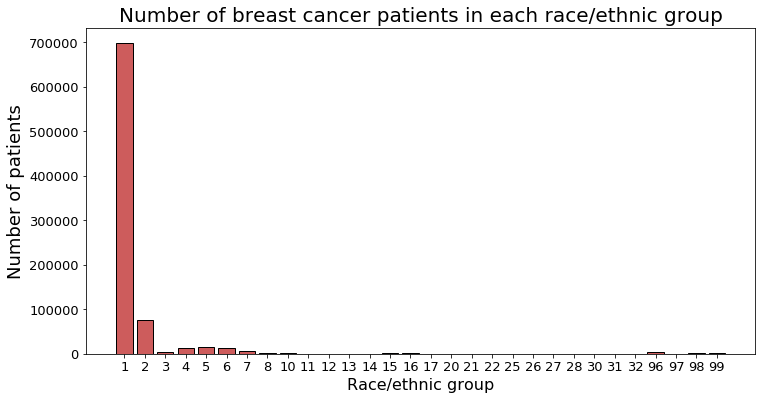

In [35]:
### Create bar graph ###

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x=np.arange(0,len(race_counts)), height=race_counts_df['count'].astype(float), color=color_palette[5], edgecolor="black")
ax.set_title('Number of breast cancer patients in each race/ethnic group', fontsize=20)
ax.set_ylabel('Number of patients', fontsize=18)
ax.set_xlabel('Race/ethnic group', fontsize=16)
plt.xticks(ticks=np.arange(0, len(race_counts)), labels=list(race_counts_df.index))
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("bargraph-raw-counts-race-group.jpeg")

plt.show()

The above graph appears to be extremely biased towards the white race group. A skeptic may worry that breast cancer is being severely under-reported in other race groups.

We do, however, have to take into account the make-up of the US population. We should normalize each of these breast cancer counts in each race group by the total number of people in that race group.

The [U.S. Census Bureau](https://www.census.gov/quickfacts/fact/table/US#) will be the best source of information for this. Unfortunately, the census considers many fewer race groups than the SEER dataset does. I will therefore have to slot the multiple SEER race groups into each Census Bureau category (e.g. the Korean SEER category will form part of the Asian Census Bureau category).

We will focus on the following race groups: White, Black/African-American, American Indian/Alaska Native, Asian and Native Hawaiian/other Pacific Islander. SEER individuals with a race recorded as *Other* (code 98) or *Unknown* (code 99) have been ignored.

In [36]:
race_stats = pd.read_csv(data_dir+'census-race-stats.csv')
race_stats = race_stats.set_index('race')
race_stats

,percent_of_pop
race,
white,0.765
black/african-american,0.134
american-indian/alaska-native,0.013
asian,0.059
native-haiwaiian/other-pacific-islander,0.002
two/more races,0.027


In [37]:
pop = 327167434 #US population [from the US Census Bureau (link above)]

In [38]:
### Determine raw number of people in each race group according to census ### 

denoms = [race_stats.loc[r, 'percent_of_pop']*pop for r in race_stats.index]
denoms

[250283087.01,
 43840436.156,
 4253176.642,
 19302878.606000002,
 654334.868,
 8833520.718]

In [39]:
### Combine SEER race groups into census race groups ###

white = [1]
black = [2]
n_american = [3]
asian = [i for i in range(4,9)] + [x for x in range(10,18)] + [x for x in range(20,23)] + \
[x for x in range(25,29)] + [x for x in range(30,33)] + [96]
pacific = [97]

In [40]:
### Tally counts of breast cancer cases in each race category ###

counts = [0]*5

for i in race_counts_df.index:
    if i in white:
        ix = 0
    elif i in black:
        ix = 1
    elif i in n_american:
        ix = 2
    elif i in asian:
        ix = 3
    elif i in pacific:
        ix = 4
    else:
        ix = -1
        
    if ix > -1:
        counts[ix] += race_counts_df.loc[i, 'count']

In [41]:
counts

[697456, 76032, 4099, 59351, 348]

In [42]:
### Calculate proportion of individuals with breast cancer in each race group ###

props = []

for i in range(len(counts)):
    props.append(counts[i]/denoms[i])

props

[0.0027866685213617064,
 0.0017342893152214741,
 0.0009637502377687515,
 0.003074722750499589,
 0.0005318377745384034]

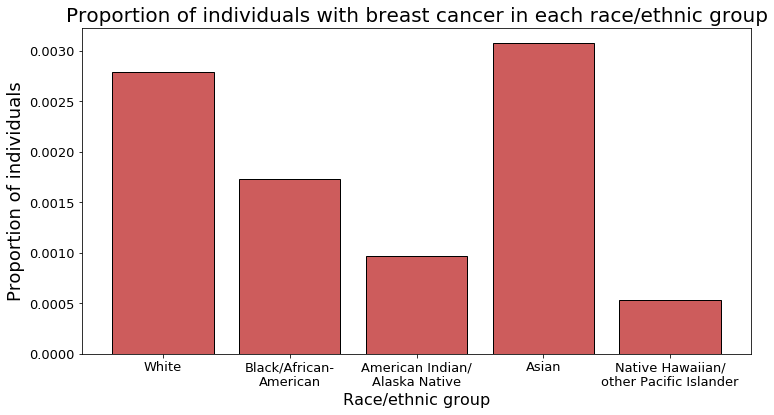

In [43]:
### Create bar graph ###

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x=np.arange(0,len(counts)), height=props, color=color_palette[5], edgecolor="black")
ax.set_title('Proportion of individuals with breast cancer in each race/ethnic group', fontsize=20)
ax.set_ylabel('Proportion of individuals', fontsize=18)
ax.set_xlabel('Race/ethnic group', fontsize=16)
race_groups = ["White", "Black/African-\nAmerican", "American Indian/\nAlaska Native", "Asian", "Native Hawaiian/\nother Pacific Islander"]
plt.xticks(ticks=np.arange(0, len(counts)), labels=race_groups)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig("bargraph-prop-race-group.jpeg")

plt.show()

The above graph should hopefully substantially assuade a skeptic. The differences between breast cancer cases in each of these race groups are not nearly as stark as in the first graph, indicating that there is a relatively fair representation of breast cancer cases across all race groups. Even if every single breast cancer patient in the US was documented, the proportion of cases in each race group would not be equal because it is known that breast cancer, like many other diseases, has difference incidence rates in different populations ([CDC](https://www.cdc.gov/cancer/dcpc/research/articles/breast_cancer_rates_women.htm), [Cleveland Clinic](https://my.clevelandclinic.org/health/articles/10310-breast-cancer-facts-ethnicity--race), [NCBI](https://www.ncbi.nlm.nih.gov/pubmed/15224974)).